In [1]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
with ZipFile('dogs-vs-cats-redux-kernels-edition.zip') as zip_ref:
    zip_ref.extractall('ref_zip')
with ZipFile('ref_zip/train.zip') as zip_ref:
    zip_ref.extractall()

KeyboardInterrupt: 

In [17]:
filenames = os.listdir('train')
labels = ['dog' if 'dog' in name else 'cat' for name in filenames]
df = pd.DataFrame({'filename' : filenames, 'label' : labels})
print(df.head())

        filename label
0   cat.9920.jpg   cat
1  cat.11403.jpg   cat
2   cat.2180.jpg   cat
3   cat.1109.jpg   cat
4    dog.696.jpg   dog


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [28]:
igen = ImageDataGenerator(
    rescale = 1./255,        #사이즈 재정립
    validation_split = 0.2, #테스트 비율 나누기
    shear_range = 0.2,      #기울기
    zoom_range = 0.2,       #확대비율
    horizontal_flip = True  #좌우반전
)
train_gen = igen.flow_from_dataframe(
    df,
    directory = 'train',
    x_col = 'filename',
    y_col = 'label',
    target_size = (128, 128),
    batch_size = 32,
    class_mode = 'binary',
    subset = 'training',
    seed = 42
)
val_gen = igen.flow_from_dataframe(
    df,
    directory = 'train',
    x_col = 'filename',
    y_col = 'label',
    target_size = (128, 128),
    batch_size = 32,
    class_mode = 'binary',
    subset = 'validation',
    seed = 42
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
#lenet-5 // 58%, cnn // 95%, SGD // 70% (왠만하면 아담, 정확도 높이고 싶으면 한번쯤 쓰기) 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, Activation, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model

In [29]:
cnn = Sequential()
cnn.add(Conv2D(32,(3,3), input_shape = (128,128,3)))#극소 패턴 추출
cnn.add(BatchNormalization())#출력을 정규화, 경사 폭주를 막음
cnn.add(Activation('relu'))
cnn.add(Conv2D(32,(3,3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))#맵 사이즈를 줄여 패턴찾기
cnn.add(Dropout(0.25))#과적합 방지

cnn.add(Conv2D(64,(3,3)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(Conv2D(64,(3,3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(128,(3,3)))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(128,(3,3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(256,(3,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(GlobalAveragePooling2D())#체널별 평균을 이용해 파라미터 감소
cnn.add(Dense(units = 128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(units = 1, activation = 'sigmoid'))
cnn.summary()

/home/yongjun-kim/tf-torch/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 11, 11, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 616,097 (2.35 MB)

 Trainable params: 615,649 (2.35 MB)

 Non-trainable params: 448 (1.75 KB)

In [30]:
cnn.compile(loss = 'binary_crossentropy', optimizer=Adam(learning_rate = 0.001), metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [31]:
hist = cnn.fit(
    train_gen,
    validation_data = val_gen,
    epochs = 30,
    callbacks = [early_stop, reduce_lr]
)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 89s 126ms/step - accuracy: 0.5161 - loss: 0.7029 - val_accuracy: 0.5004 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 103ms/step - accuracy: 0.5961 - loss: 0.6726 - val_accuracy: 0.5432 - val_loss: 0.6755 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 108ms/step - accuracy: 0.6401 - loss: 0.6424 - val_accuracy: 0.6064 - val_loss: 0.6411 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms/step - accuracy: 0.6697 - loss: 0.6162 - val_accuracy: 0.6126 - val_loss: 0.6783 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms/step - accuracy: 0.7002 - loss: 0.5846 - val_accuracy: 0.5956 - val_loss: 0.7029 - learning_rate: 0.0010
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 108ms/step - accuracy: 0.7243 - loss: 0.5567 - val_accuracy: 0.6968 - val_loss: 0.6029 - learning_rate: 0.0010
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 108ms/step - accuracy: 0.7

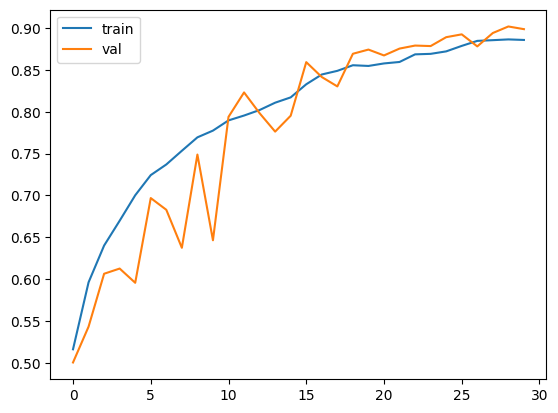

In [32]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train','val'])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

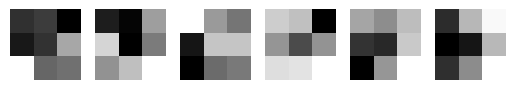

In [33]:
filters, biases = cnn.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
n_filters = 6
for i in range(n_filters):
    f = filters[:, :, :, i]
    plt.subplot(1,n_filters, i+1)
    plt.imshow(f[:,:,0], cmap = 'gray')
    plt.axis('off')
plt.show